In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pickle
import random
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import heapq

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from PIL import Image
from IPython.display import display

from random import randint
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize


In [2]:
os.getcwd()

'/raid/home/arend036/msc_pim/Thesis-Scripts'

In [3]:
concept_score = pd.read_csv('../data/concept_scores.csv', index_col = 0)

In [4]:
WORD_EMBEDDING_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained' 
GLOVE_PATH = WORD_EMBEDDING_PATH + '/glove.42B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
SON_VECTOR_PATH = '../data/son_tensors.pickle'

## Cluster Scenic-Or-Not images

Compute the matrix of activations from all SoN images.

In [5]:
with open(SON_VECTOR_PATH, 'rb') as handle:
    son_acts = pickle.load(handle)

In [6]:
if os.path.exists('../data/son_matrix.npy'):
    son_matrix = np.load('../data/son_matrix.npy')

else:
    cuda = torch.device('cuda')
    son_matrix = son_acts[list(son_acts.keys())[0]].unsqueeze(0).cuda()

    for i in tqdm(range(1, len(son_acts.keys()))):
        img_tensor = son_acts[list(son_acts.keys())[i]].unsqueeze(0).cuda()
        son_matrix = torch.cat((son_matrix, img_tensor), 0).cuda()

    son_matrix = np.asarray(son_matrix.to(device='cpu'))
    np.save('../data/son_matrix.npy', son_matrix)

In [7]:
'52642' in son_acts.keys()

False

Apply a k-means clustering to cluster all images into 50 groups. A mini-batch clustering is applied as the sample size is 212100 which requires high computational time. Several amount of clusters have been tried, at around 50 no 'structure' can be seen in the clusters. The clusters are visualized with t-SNE. 

In [8]:
son_matrix_norm = normalize(son_matrix)

In [9]:
np.random.seed(42)
num_clusters = 50
kmeans = MiniBatchKMeans(n_clusters = num_clusters, batch_size = 100, init = 'k-means++', max_iter = 2000)

kmeans.fit(son_matrix_norm)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=2000, max_no_improvement=10,
                n_clusters=50, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [10]:
clusters = kmeans.cluster_centers_

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(clusters)

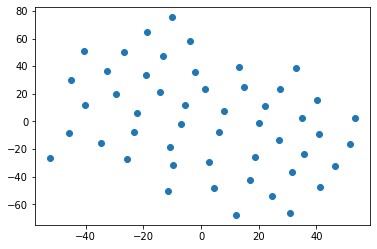

In [11]:
plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1])
plt.show()

In [12]:
labels = kmeans.labels_

In [13]:
cluster_dict = {}
for i in tqdm(range(num_clusters)):
    concept_score_cluster = concept_score.loc[(labels == i),:]
    mean_score = concept_score_cluster.mean()
    cluster_dict['cluster_' + str(i)] = mean_score[mean_score > 0].sort_values(ascending=False)

In [14]:
for key in cluster_dict.keys():
    print(key)
    print(cluster_dict[key])
    print('\n')

cluster_0
tree                   573.042931
bush                   456.771779
embankment             300.398421
fence                  209.552665
earth                  144.648371
field                  129.984944
bleachers-outdoor-s    117.324370
path                    31.186116
dtype: float64


cluster_1
building    564.502314
sky         361.960891
tree         83.975636
dtype: float64


cluster_2
building                 968.591678
tree                     819.164830
sky                      430.997549
sidewalk                 369.068132
roof                     247.067943
castle-s                  73.493412
observatory-outdoor-s     19.706165
dtype: float64


cluster_3
rock                969.364674
tree                798.813205
aqueduct-s          763.373387
bridge-s            692.920575
bridge              619.317984
bush                492.583721
trestle             287.775710
water               180.173782
embankment          158.001572
canal-natural-s     101.827092
draina

In [ ]:
# interesting clusters: 9, 12, 14, 17, 19, 22, 35, 36, 37, 41, 

In [45]:
cluster_num = 36

In [50]:
img_in_cluster = list(labels == cluster_num)
img_cluster_idx = [t for t, value in enumerate(img_in_cluster) if value]

# the images with name 201047 and 52642 do not have a tensor, so all the images above these values 
# need an additional index
img_cluster_idxs = [t+2 if t >= 201047 else t+1 if t >= 52642 else t for t in img_cluster_idx]

In [51]:
cluster_random_sample = random.sample(img_cluster_idxs, 49)

In [52]:
paths = []
for img_id in cluster_random_sample:
    try:
        #print(img_id)
        img_file = []
        img_name = str(img_id)

        for directory, _ , _ in os.walk('/raid/data/datasets/SoN/images'):
            img_file.extend(glob.glob(os.path.join(directory, img_name + '.jpg')))

        paths.append(img_file[0])
    except:
        print(img_id, ' fail')

182680  fail


IndexError: list index out of range

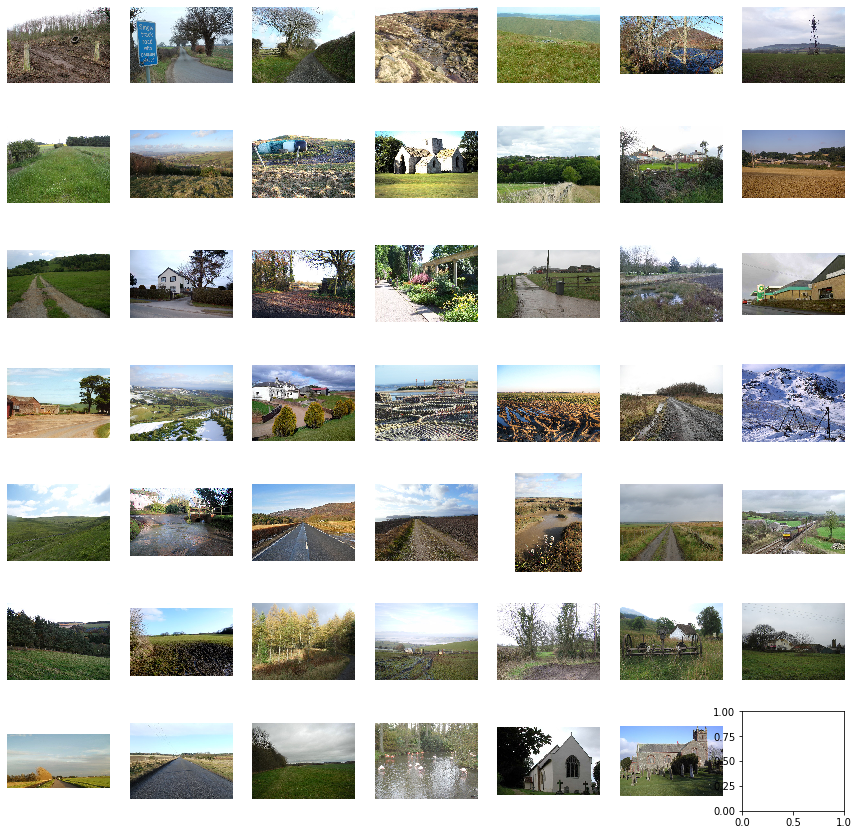

In [53]:
fig = plt.figure(figsize=(15,15))
ax = [fig.add_subplot(7, 7, i+1) for i in range(len(cluster_random_sample))]

for idx, a in enumerate(ax):
    img = plt.imread(paths[idx])
    a.axis('off')
    a.imshow(img)

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [44]:
print(img_cluster_idx[1000:1015])
print(img_cluster_idxs[1000:1015])

[153803, 153822, 153933, 154082, 154112, 154288, 154349, 154569, 154723, 154987, 155081, 155111, 155218, 155250, 155271]
[153804, 153823, 153934, 154083, 154113, 154289, 154350, 154570, 154724, 154988, 155082, 155112, 155219, 155251, 155272]


In [ ]:
cluster_imgs = son_matrix_norm[labels == cluster_num, :]
cos_sim = cosine_similarity(clusters[cluster_num].reshape(1,2048), cluster_imgs).T

AttributeError: 'dict' object has no attribute 'type'

In [448]:
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(clusters[22].reshape(1,2048), son_matrix_norm).reshape(212102,)

In [449]:
#dist_idx = np.argpartition(dist, -9)[-9:]
dist_idx = heapq.nsmallest(9, range(len(dist)), dist.take)
dist_idx

[205380, 128219, 98371, 24027, 39849, 145971, 91595, 105796, 56880]

In [450]:
ind = np.argpartition(cos_sim.reshape(212102,), -9)[-9:]
ind

array([ 56880, 105796,  91595, 205380,  24027,  39849,  98371, 128219,
       145971])

In [478]:
ind_idx = heapq.nlargest(9, range(len(cos_sim)), cos_sim.take)
ind_idx

[99, 1279, 1425, 1442, 1403, 292, 1622, 1221, 156]

In [452]:
imgs_idx = []
for idx in ind_idx:
    if idx >= 201047:
        imgs_idx.append(idx+2)
    elif idx >= 52642:
        imgs_idx.append(idx+1)
    else:
        imgs_idx.append(idx)
    

In [453]:
paths = []
for img_id in imgs_idx:
    try:
        #print(img_id)
        img_file = []
        img_name = str(img_id)

        for directory, _ , _ in os.walk('/raid/data/datasets/SoN/images'):
            img_file.extend(glob.glob(os.path.join(directory, img_name + '.jpg')))

        paths.append(img_file[0])
    except:
        print(img_id, ' fail')


128220  fail


In [ ]:
fig = plt.figure(figsize=(12,12))
ax = [fig.add_subplot(3, 3, i+1) for i in range(len(ind))]

for idx, a in enumerate(ax):
    img = plt.imread(paths[idx])
    a.axis('off')
    a.imshow(img)

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [366]:
son_matrix[212000,:]

array([0.02427758, 0.39087665, 0.11547251, ..., 0.3146474 , 0.20419319,
       0.071063  ], dtype=float32)

In [367]:
son_acts['212002']

tensor([0.0243, 0.3909, 0.1155,  ..., 0.3146, 0.2042, 0.0711])

In [4]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

In [7]:
# takes about 4 - 8min to run on guanabana

embedding_dict = {} # 1.9M words

with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vector

In [110]:
concepts = list(cavs_broden.keys())
embedding_concepts = [c for c in concepts if c in embedding_dict.keys()]

In [111]:
len(embedding_concepts)

321

In [10]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

For all the concepts which have a concept activation vector and have a word embedding, the CAVs are concatenated into a matrix. Also the matching word embeddings are concatenated into a matrix. <br>
These are then split in 75% training and 25% test data and converted into a TensorDataset

In [25]:
x_cavs = torch.from_numpy(cavs_broden[embedding_concepts[0]]['cav']).float()
y_word_vec = torch.from_numpy(embedding_dict[embedding_concepts[0]]).unsqueeze(0).float()

for i in range(1, len(embedding_concepts)):
    cav = torch.from_numpy(cavs_broden[embedding_concepts[i]]['cav']).float()
    x_cavs = torch.cat((x_cavs, cav), 0)
    
    word_vec = torch.from_numpy(embedding_dict[embedding_concepts[i]]).unsqueeze(0).float()
    y_word_vec = torch.cat((y_word_vec, word_vec), 0)


In [37]:
# randomly sample 25% indices of the matrices 
random.seed(42)
random_idxs = random.sample(range(len(embedding_concepts)), 80)
random_idxs.sort()

X_train = np.delete(x_cavs, random_idxs, axis=0)
X_test = x_cavs[random_idxs,:]

y_train = np.delete(y_word_vec, random_idxs, axis=0)
y_test = y_word_vec[random_idxs,:]

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 10)
test_loader = DataLoader(test_dataset, batch_size = 10)

In [38]:
y_concepts = [embedding_concepts[i] for i in random_idxs] # store the words/concepts which will be used for testing
x_concepts = [word for word in embedding_concepts if word not in y_concepts]

Create a simple neural network which is a linear function between the concept activation vectors and the word embeddings

In [93]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(2048, 300)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

net = Net()        

Define the optimizer and the loss function

In [97]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

Train the neural network

In [98]:
MODEL_PATH = '../models/cav_to_word_net.pth'

if os.path.exists(MODEL_PATH):
    net = Net()
    net.load_state_dict(torch.load(MODEL_PATH))
    
else:
    
    for epoch in range(5):

        for data in train_loader:
            X, y = data

            optimizer.zero_grad()

            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        print(loss)
        torch.save(net.state_dict(), MODEL_PATH)

tensor(1.7710, grad_fn=<MseLossBackward>)
tensor(0.7898, grad_fn=<MseLossBackward>)
tensor(0.3878, grad_fn=<MseLossBackward>)
tensor(0.2123, grad_fn=<MseLossBackward>)
tensor(0.1327, grad_fn=<MseLossBackward>)


In [16]:
weights = list(net.parameters())[0]
bias = net.fc1.bias


In [126]:
idx = y_concepts.index('field')

In [127]:
with torch.no_grad():
    mountain_test = net(X_test[idx])

In [128]:
t = F.cosine_similarity(mountain_test.unsqueeze(0), y_test)

In [129]:
top_5 = np.argpartition(t.numpy(), -5)[-5:]
c = [y_concepts[i] for i in top_5]
c

['bandstand', 'lockers', 'mosque', 'waterfall', 'ruins']